In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Init

In [2]:
path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

---
# Compare Results

In [22]:
def read_cfrnn(file_name):
    df = pd.read_pickle(path + 'Logs/final/' + file_name + '_cfrnn_log')
    df = df.rename({'loss':'train_loss'}, axis=1)
    return df

In [23]:
def read_neumf(file_name):
    df = pd.read_pickle(path + 'Logs/final/' + file_name + '_neumf_log')
    df['train_loss'] = [l['loss'] for l in df.NeuMF]
    return df

In [24]:
def read_bpr(file_name):
    return pd.read_pickle(path + 'Logs/final/' + file_name + '_bpr_log')

In [25]:
file_names = ['ml_1m', 'am_like_ml', 'am_20k_users']

## All metrics comparison

In [26]:
from Evaluation import get_final_results
from visualize_results import plot_final_metrics

final_results = {}
labels = ['BPR', 'NeuMF', 'CFRNN']
colors = ['blue', 'red', 'green']
metrics_to_show = ['recall', 'ndcg']
y_labels = ['Recall', 'NDCG']
titles = ['MovieLens 1M', 'Am-like-ML', 'Amazon 20k Users']
read_funcs = [read_bpr, read_neumf, read_cfrnn]

for label, read_func in zip(labels, read_funcs):
    final_results[label] = {}
    final_results[label]['metrics'] = {}
    final_results[label]['stats'] = {}
    final_results[label]['time'] = {}
    for file_name, title in zip(file_names, titles):
        res = read_func(file_name)
        
        final_metrics, train_stats, train_time = get_final_results(res)
        final_results[label]['metrics'][file_name] = final_metrics
        final_results[label]['stats'][file_name] = train_stats
        final_results[label]['time'][file_name] = train_time

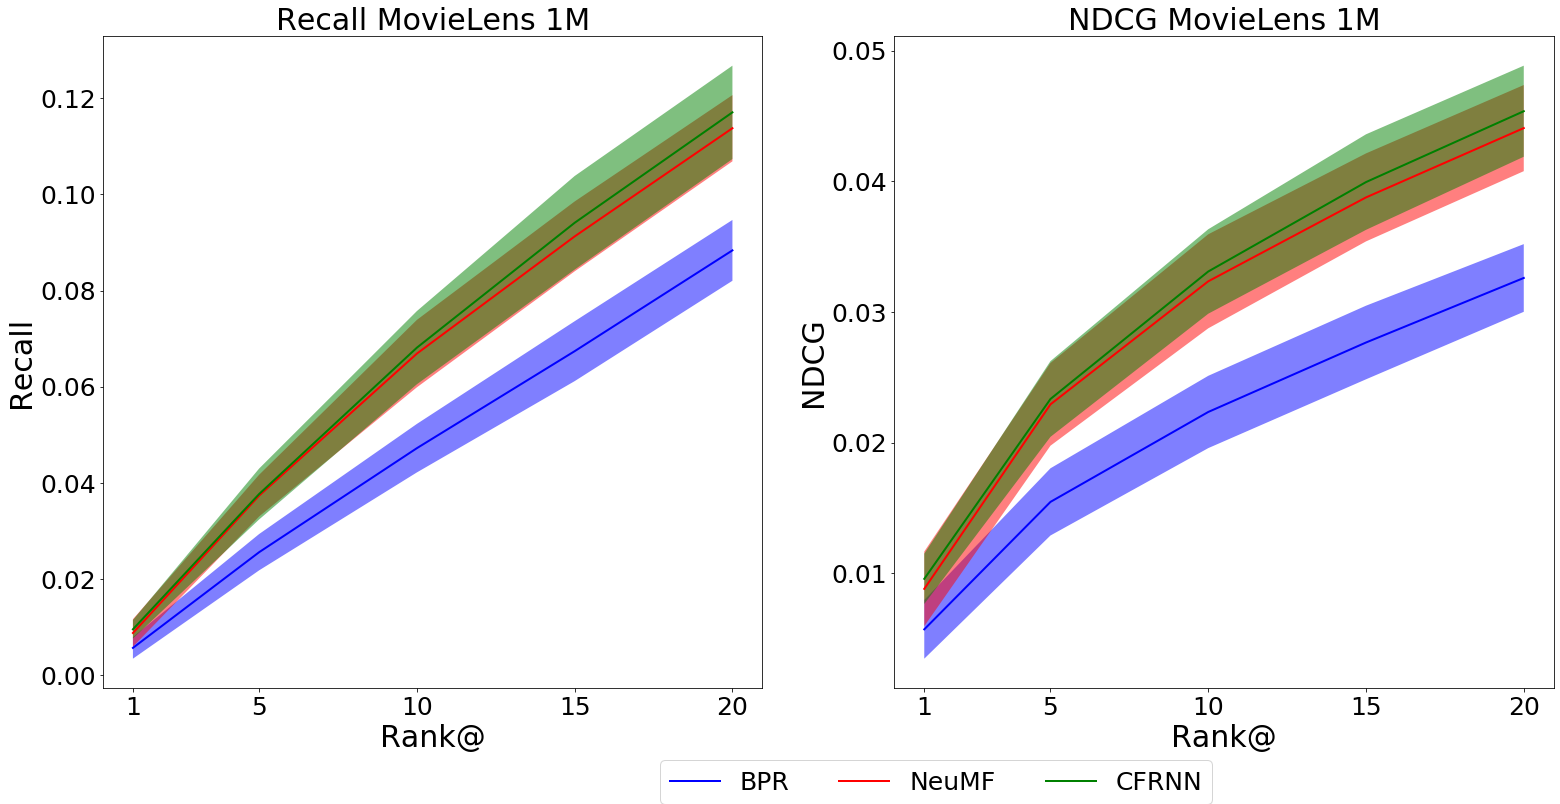

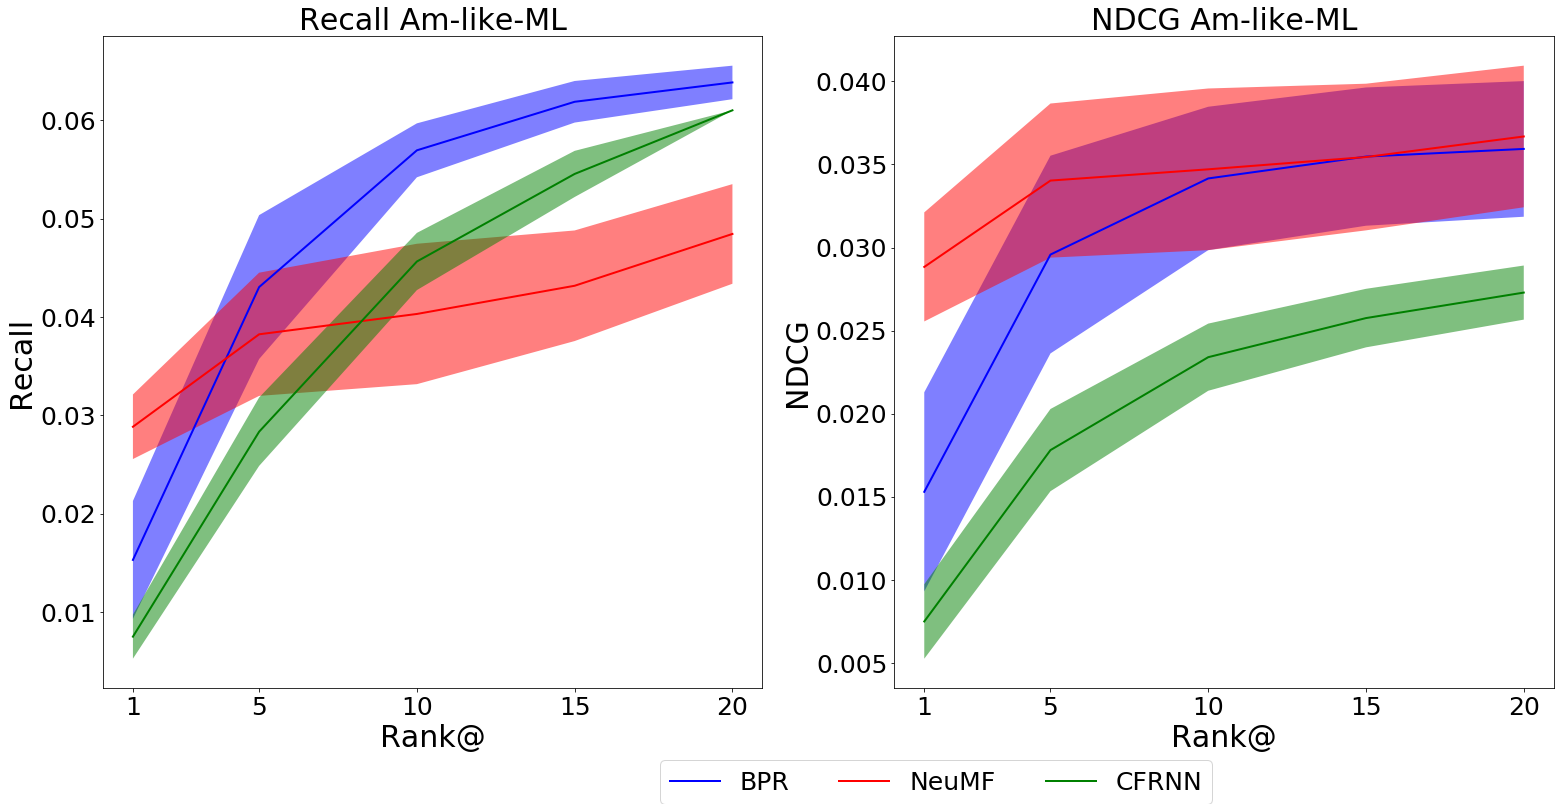

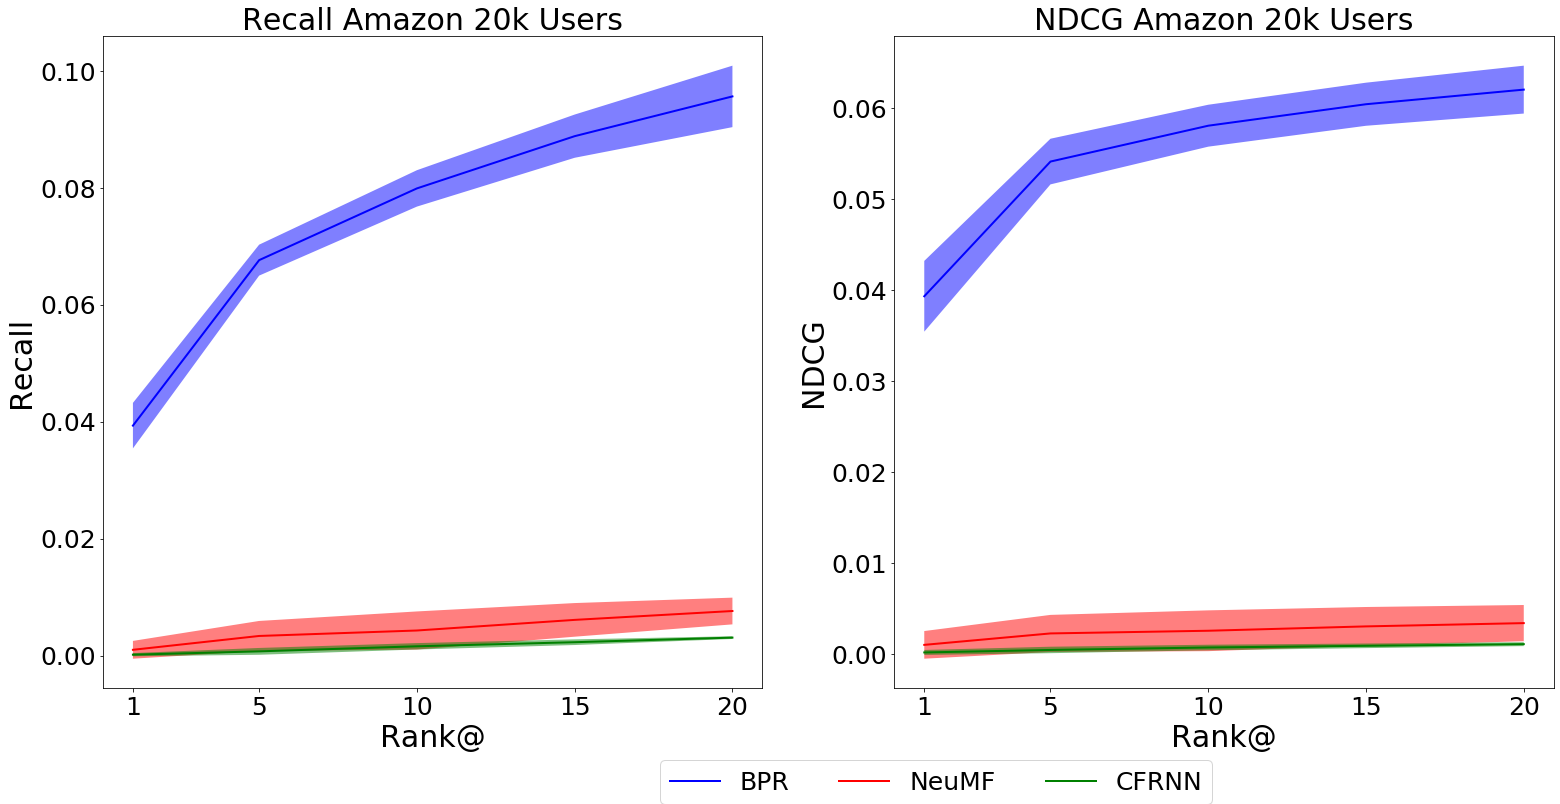

In [27]:
for file_name, title in zip(file_names, titles):
    plot_final_metrics(final_results, file_name, colors, metrics_to_show, y_labels, title, store_path=path + 'Plots/Comparison/' + file_name)

## Stats

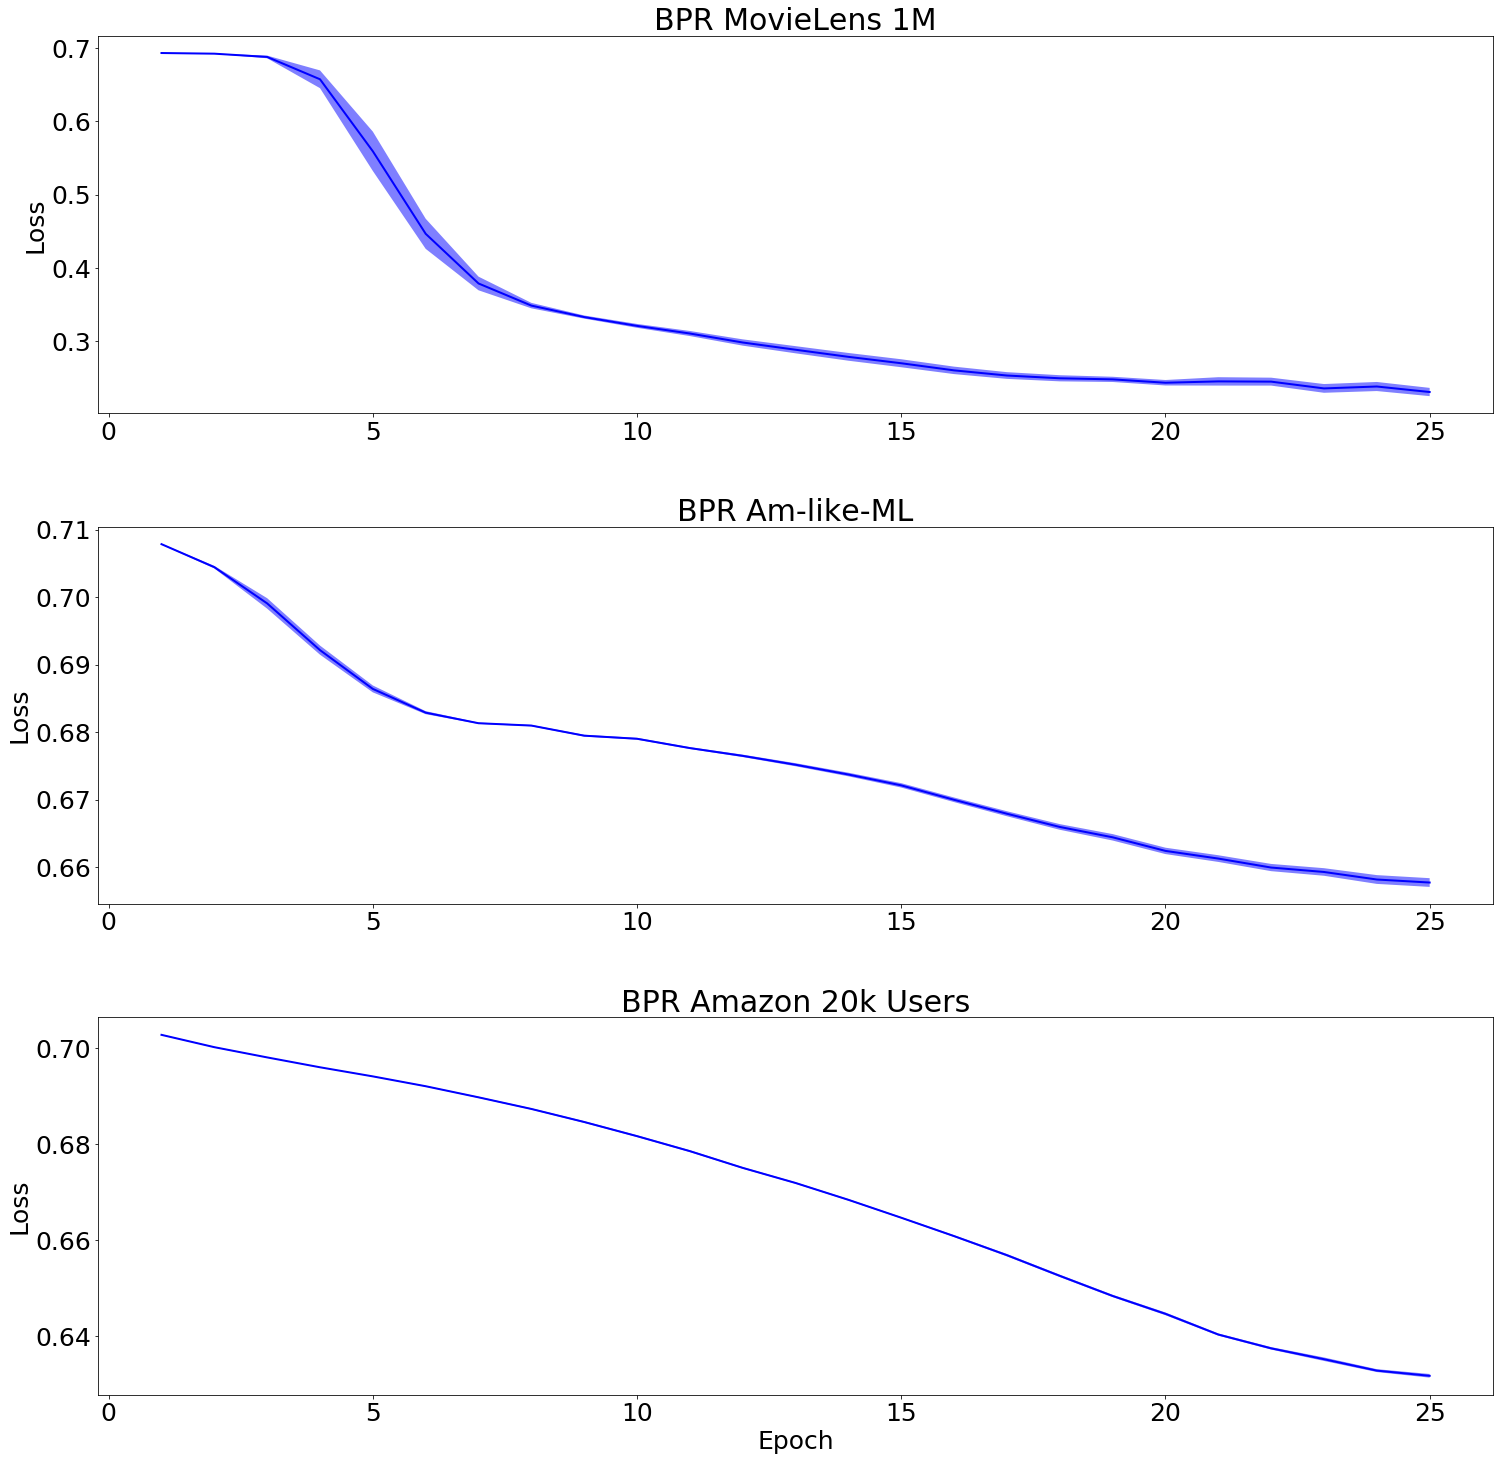

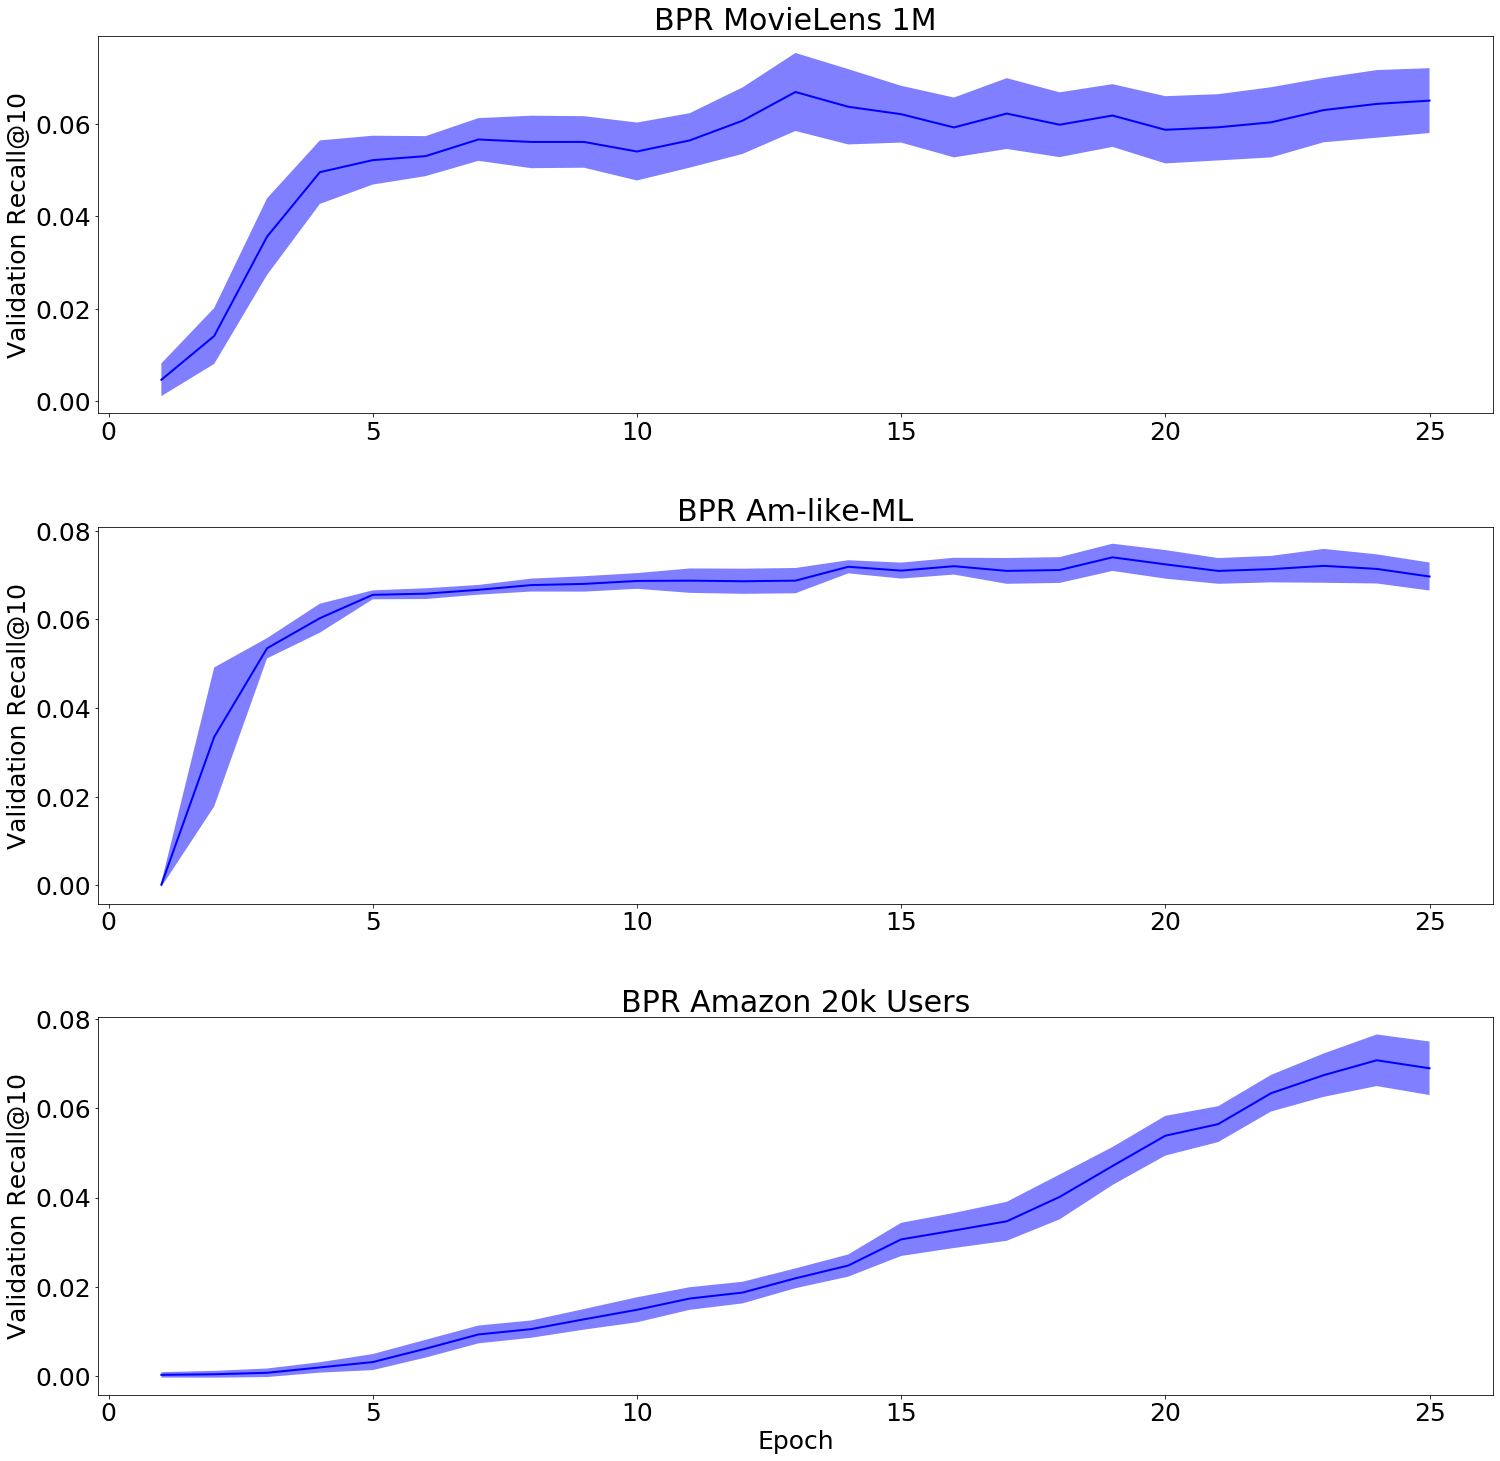

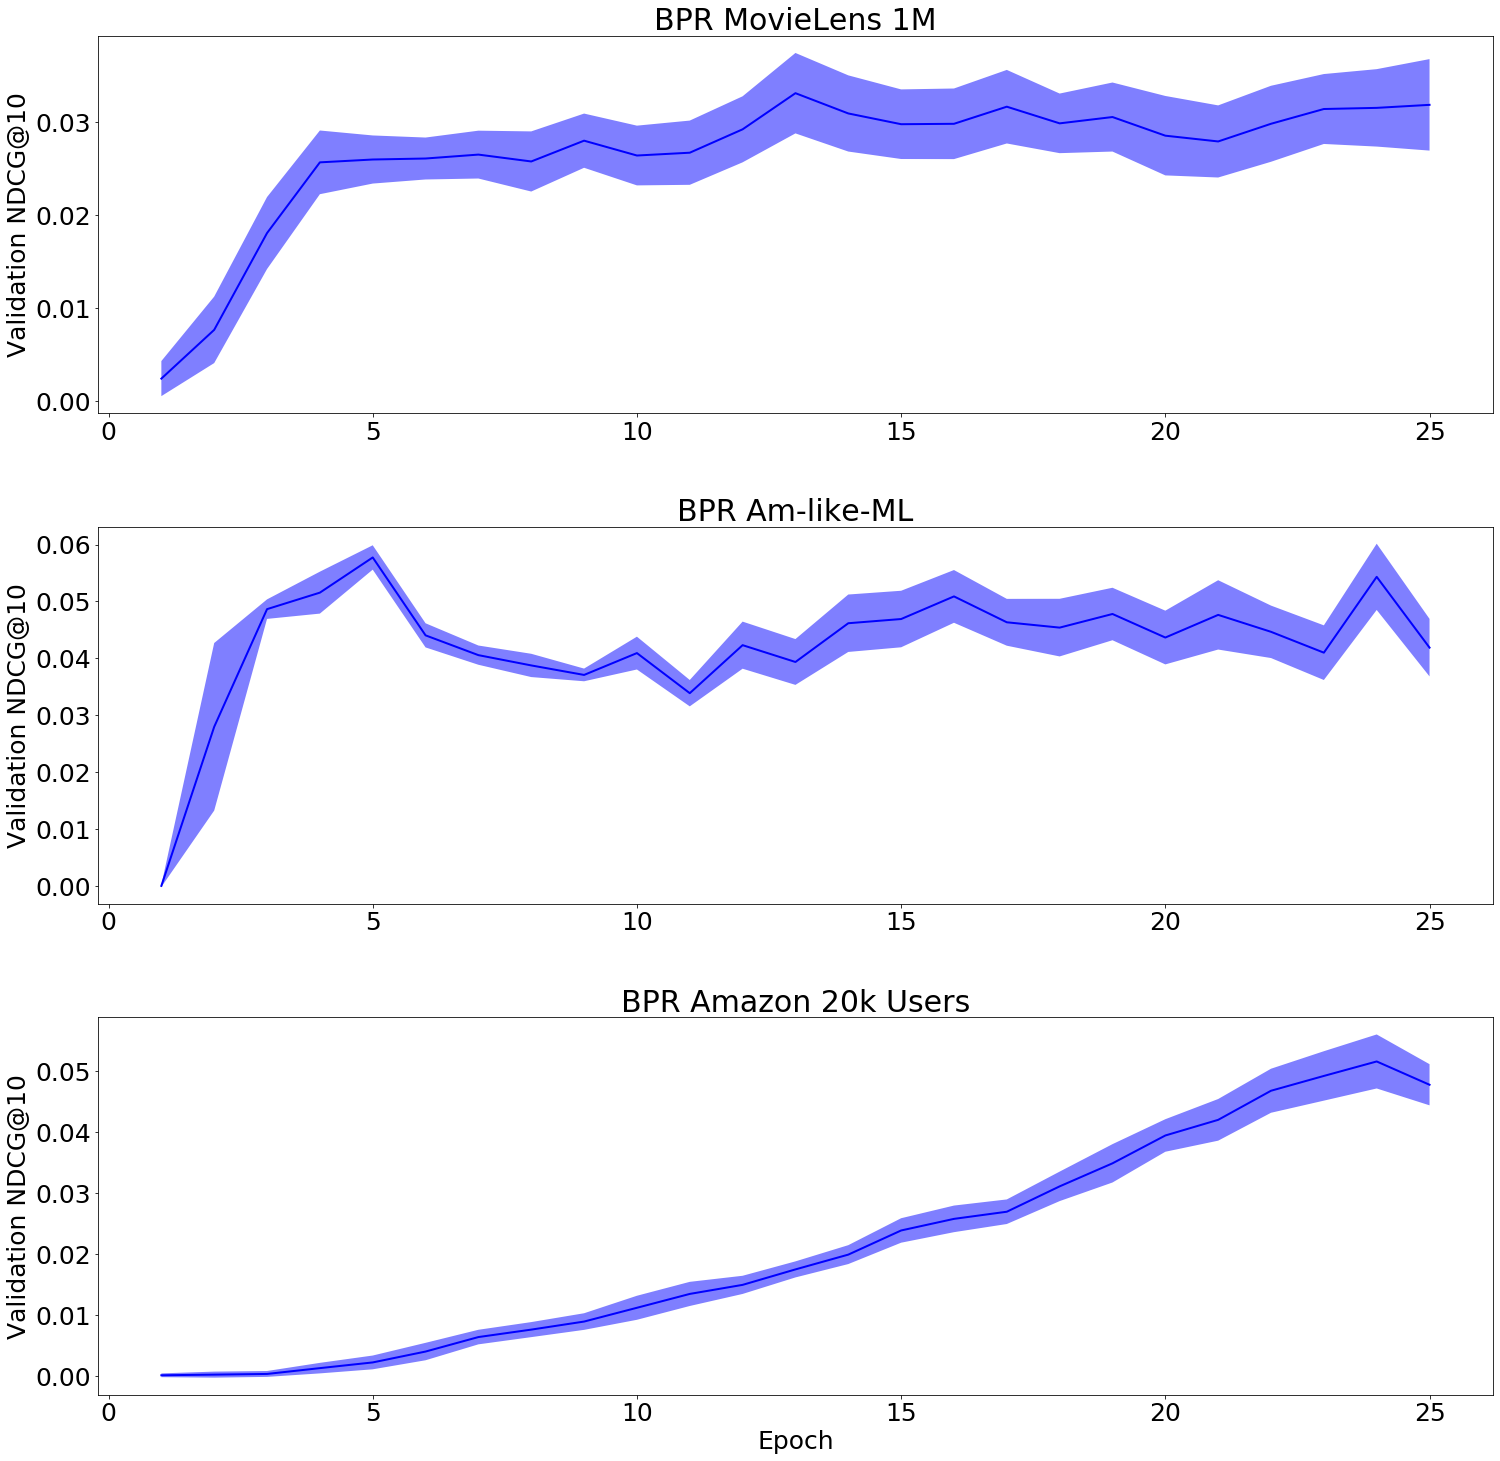

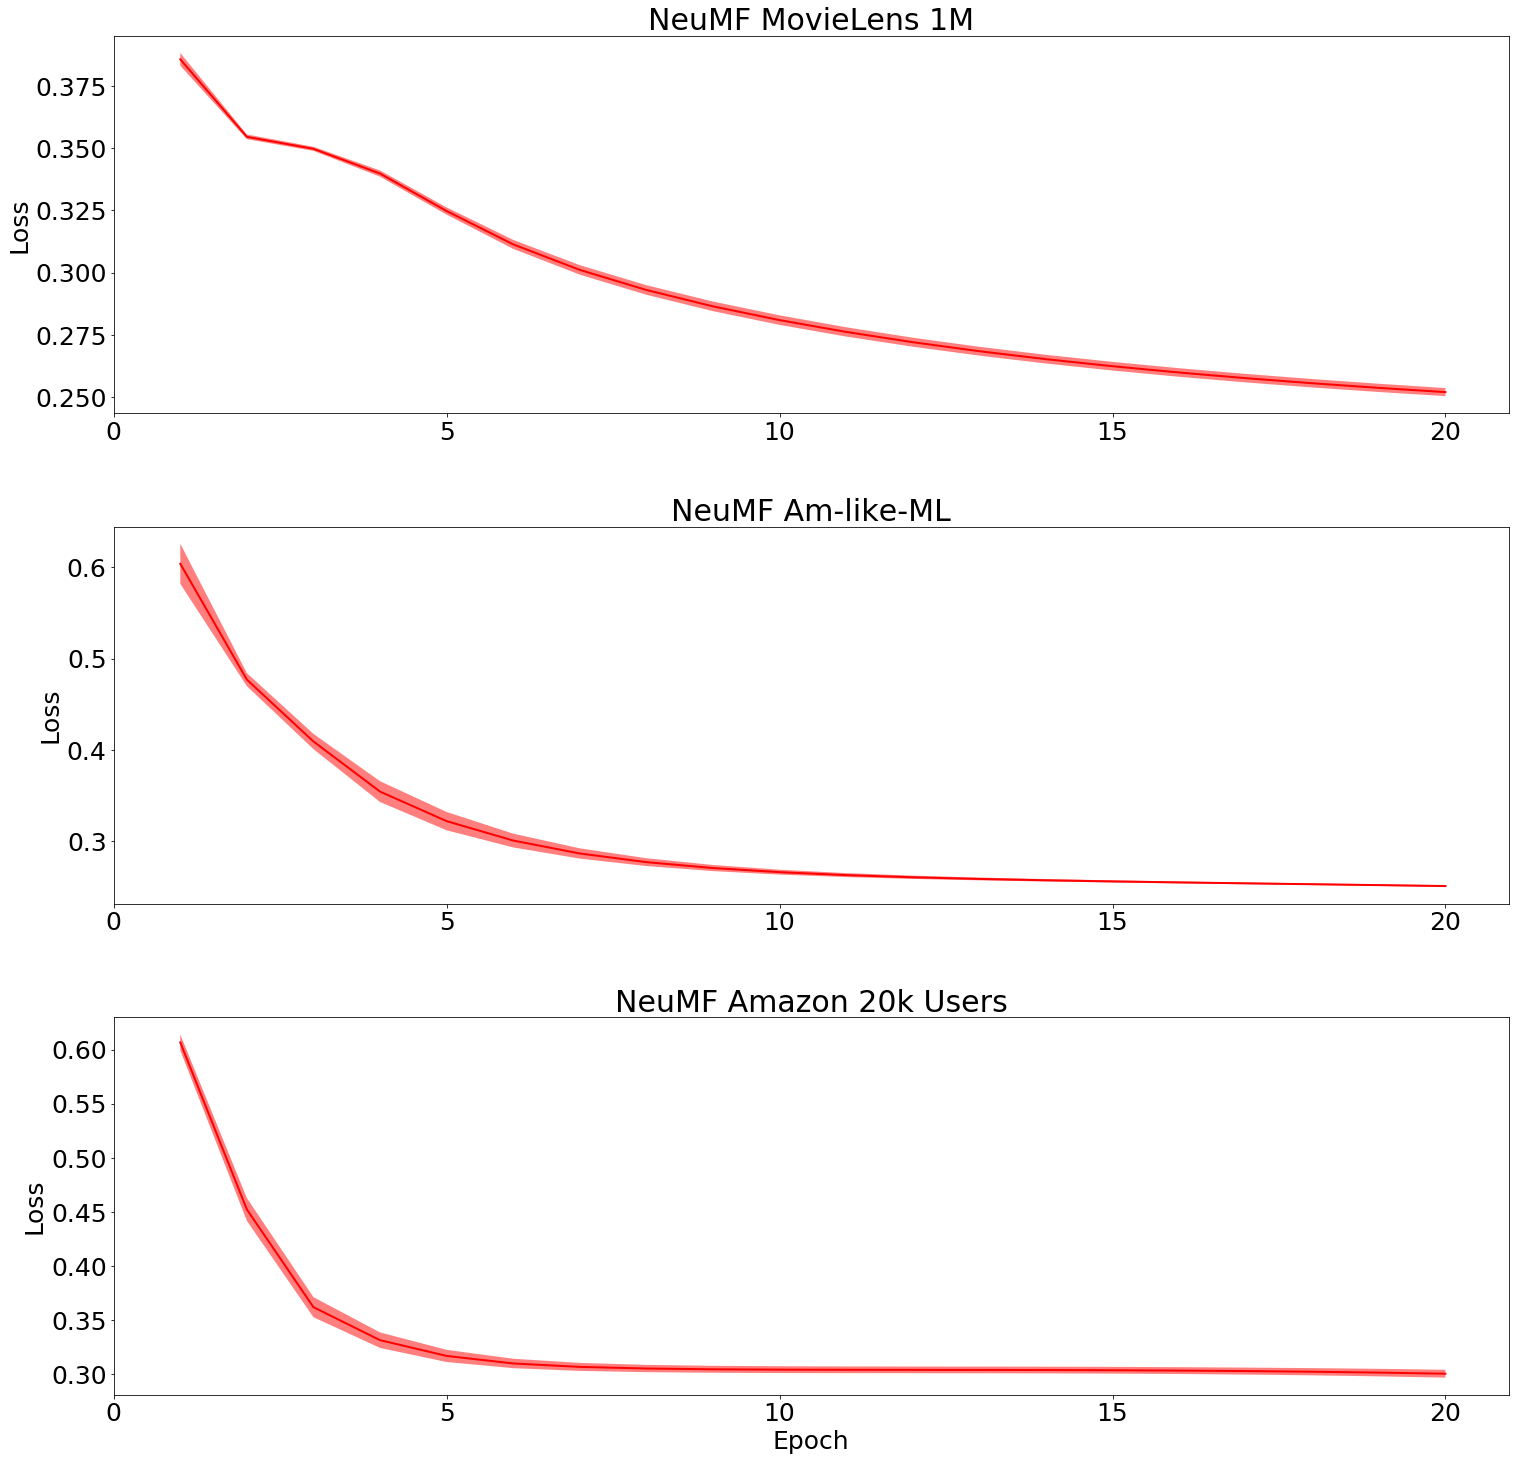

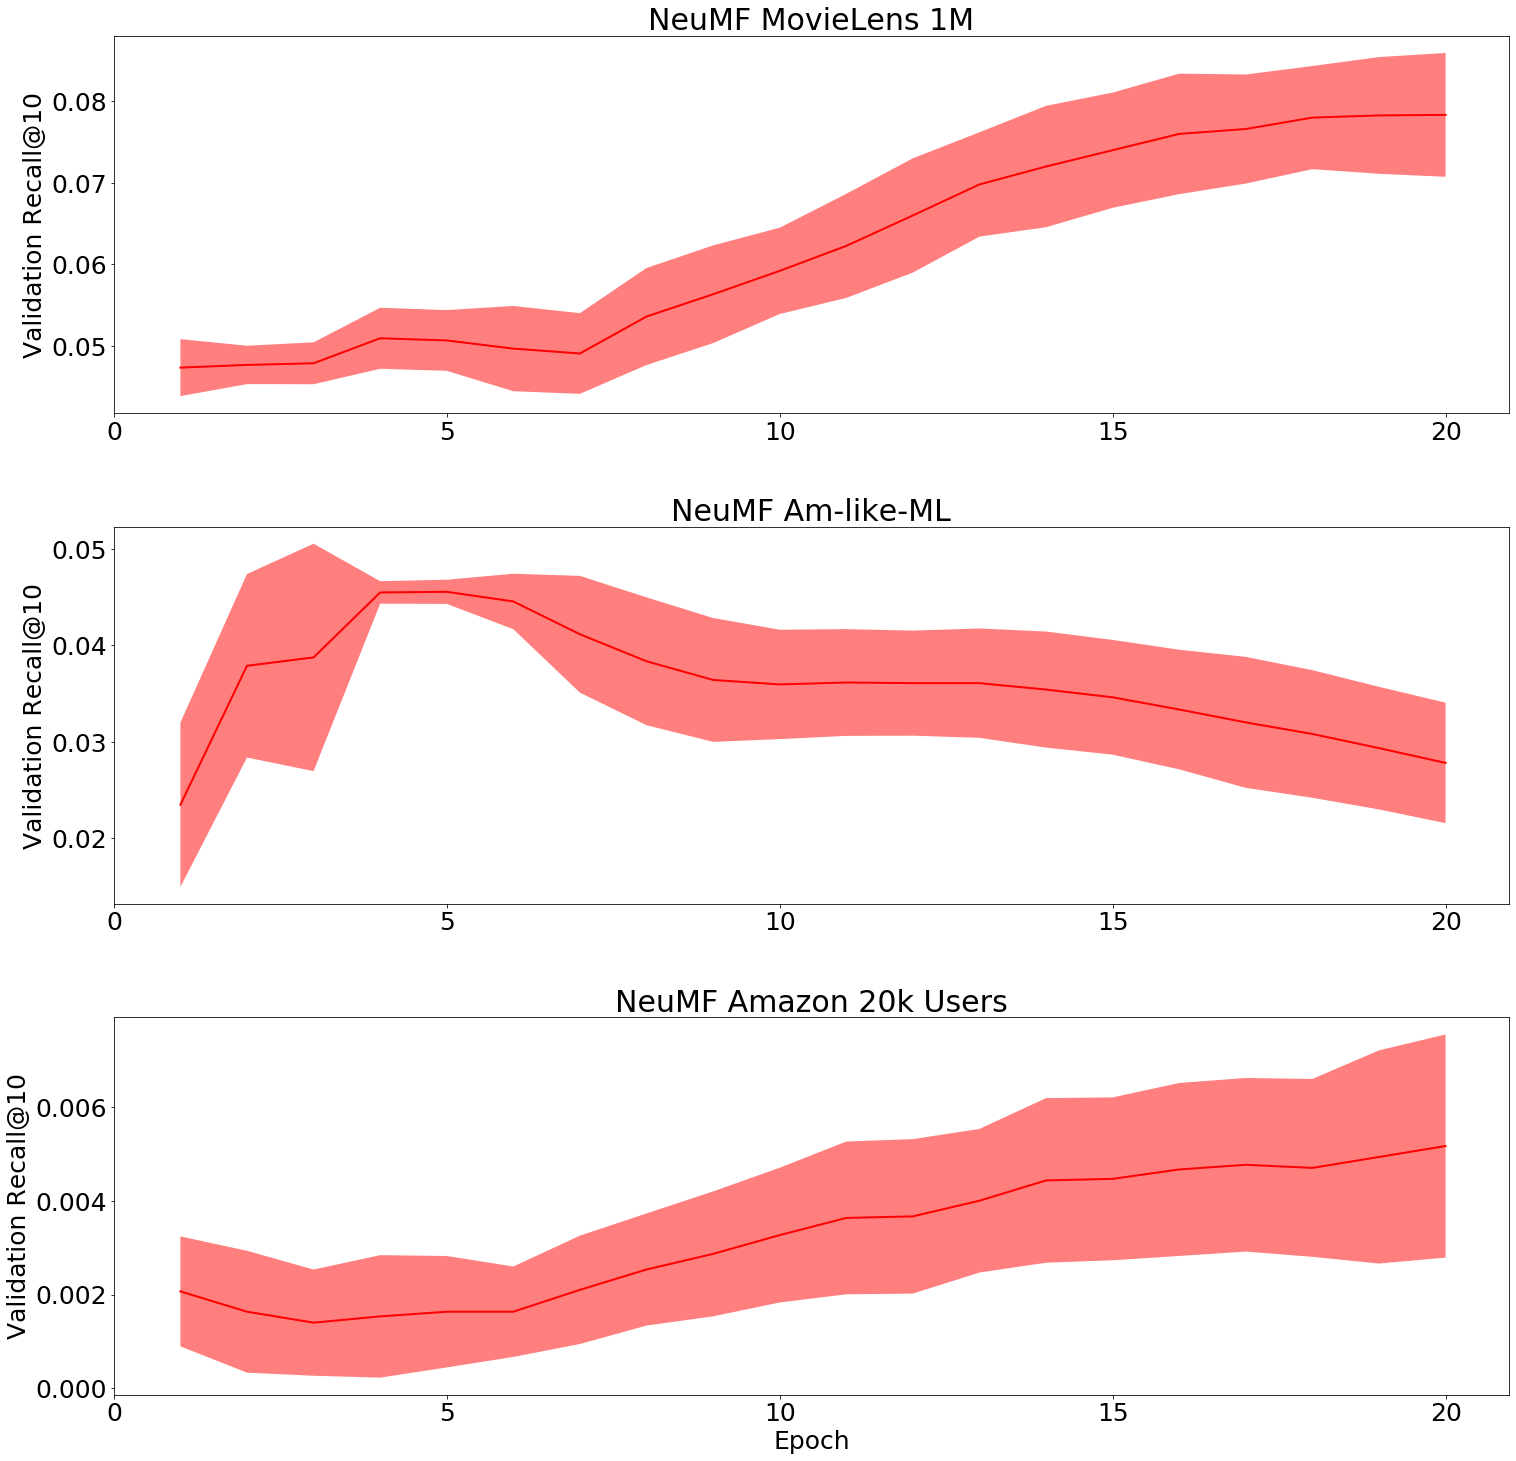

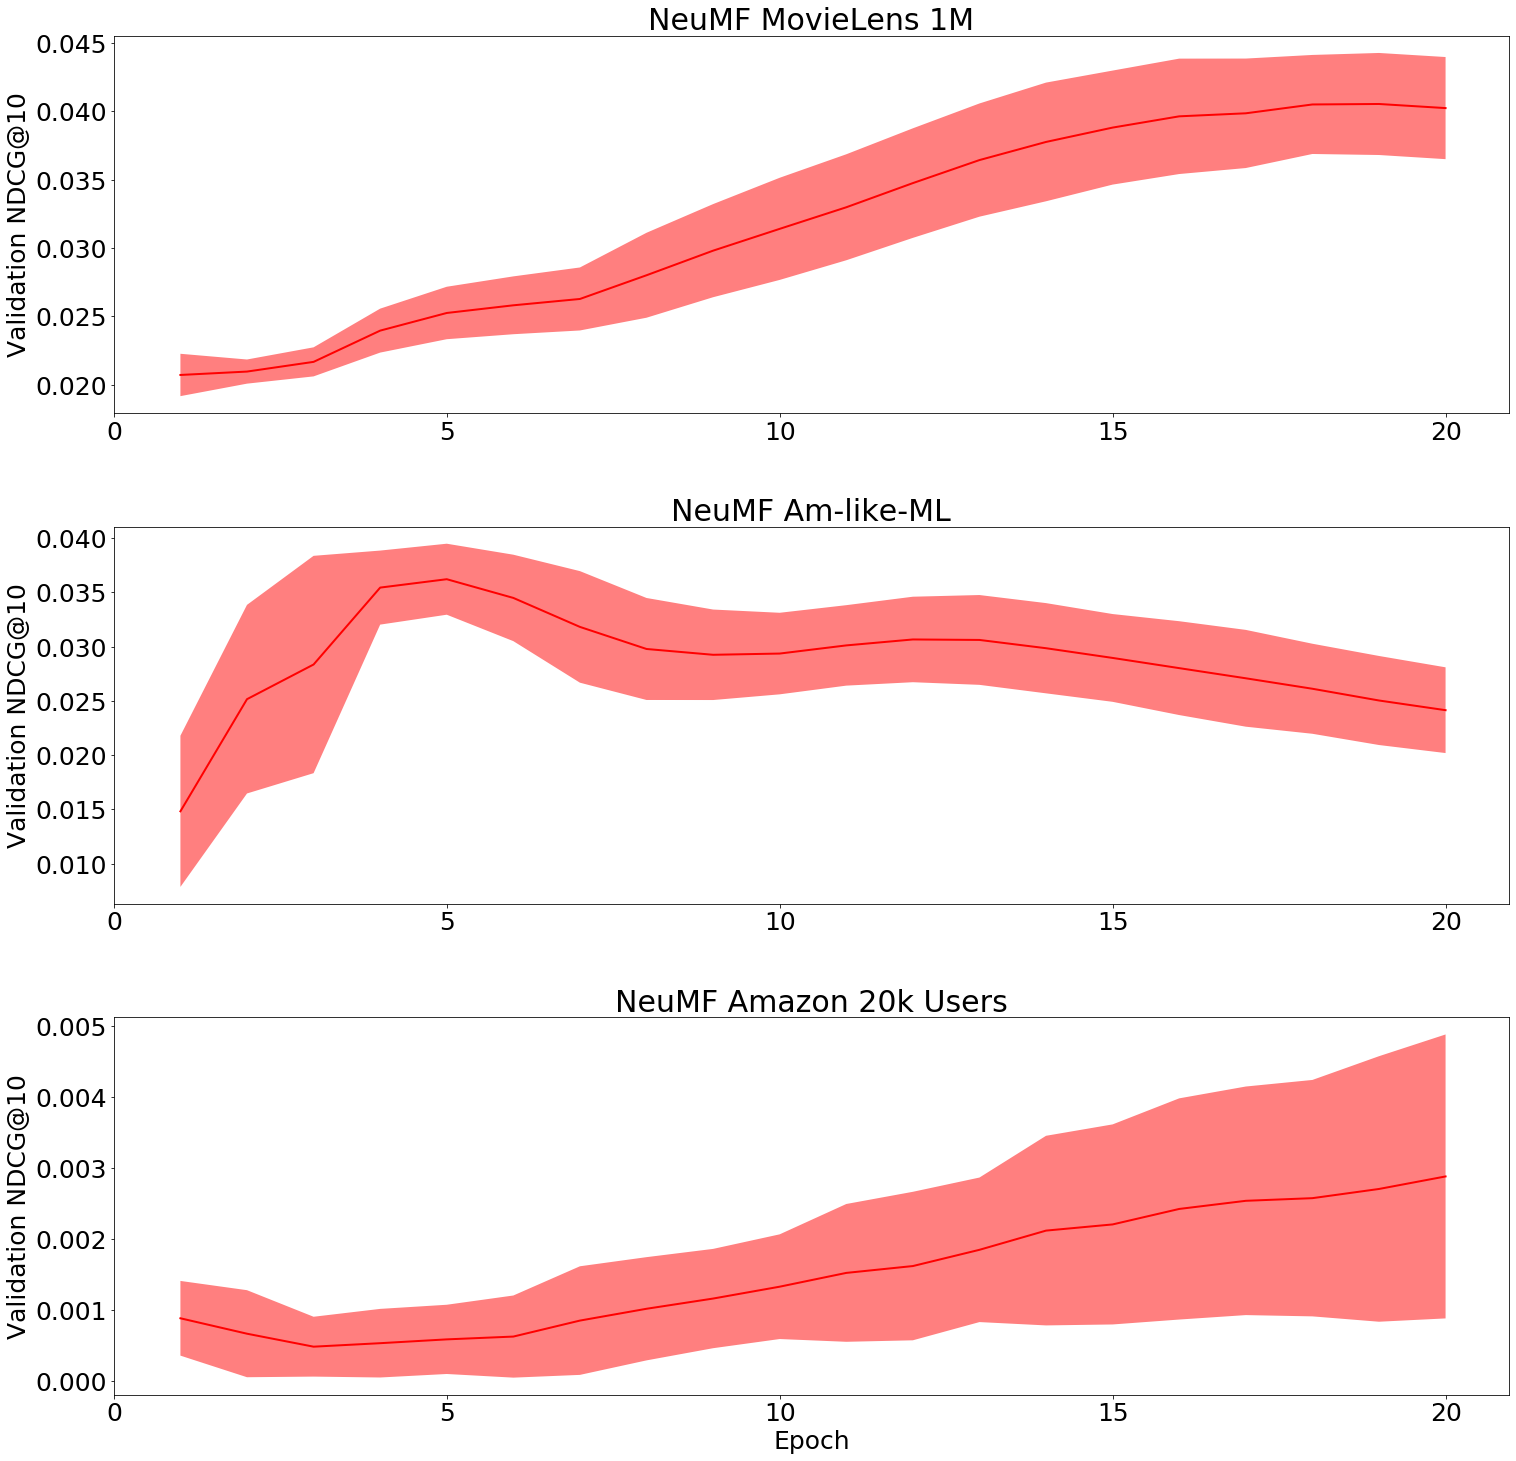

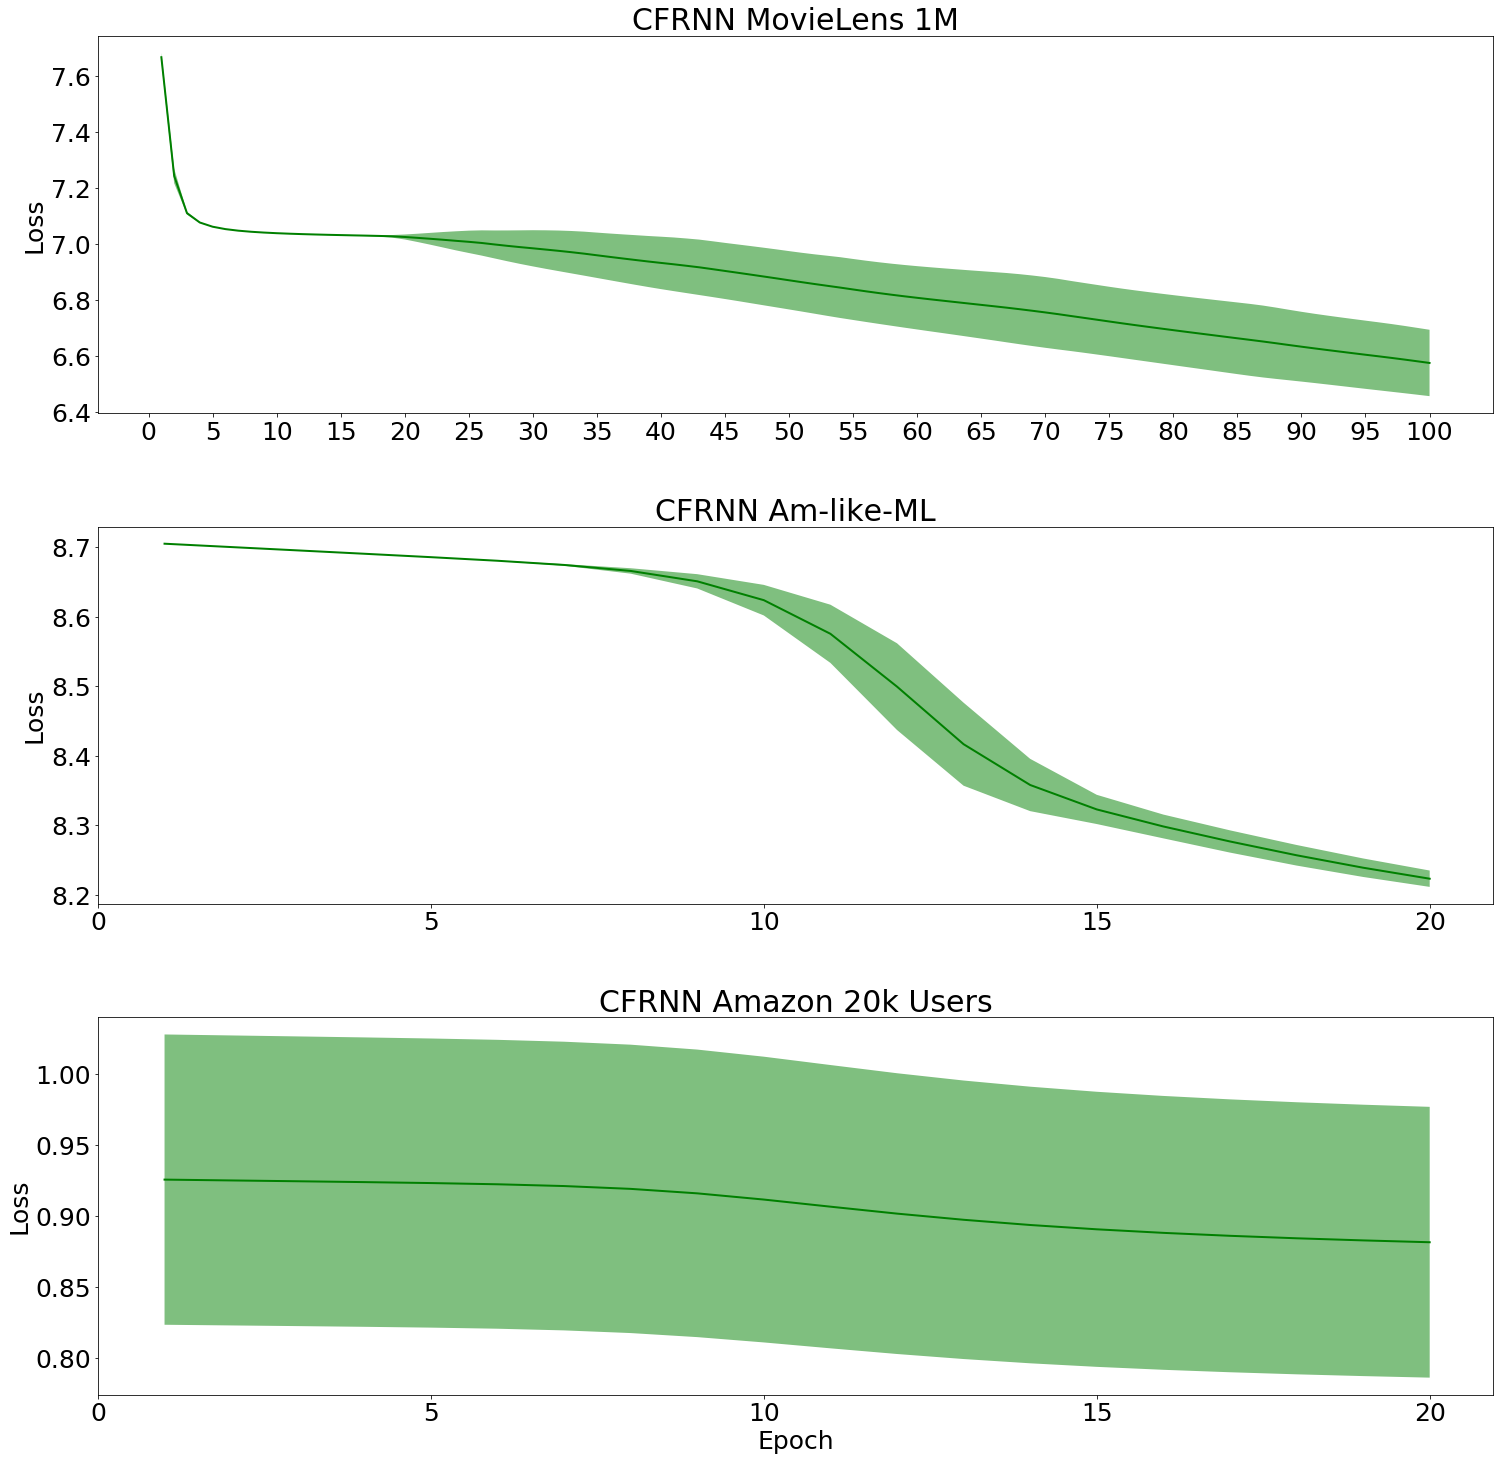

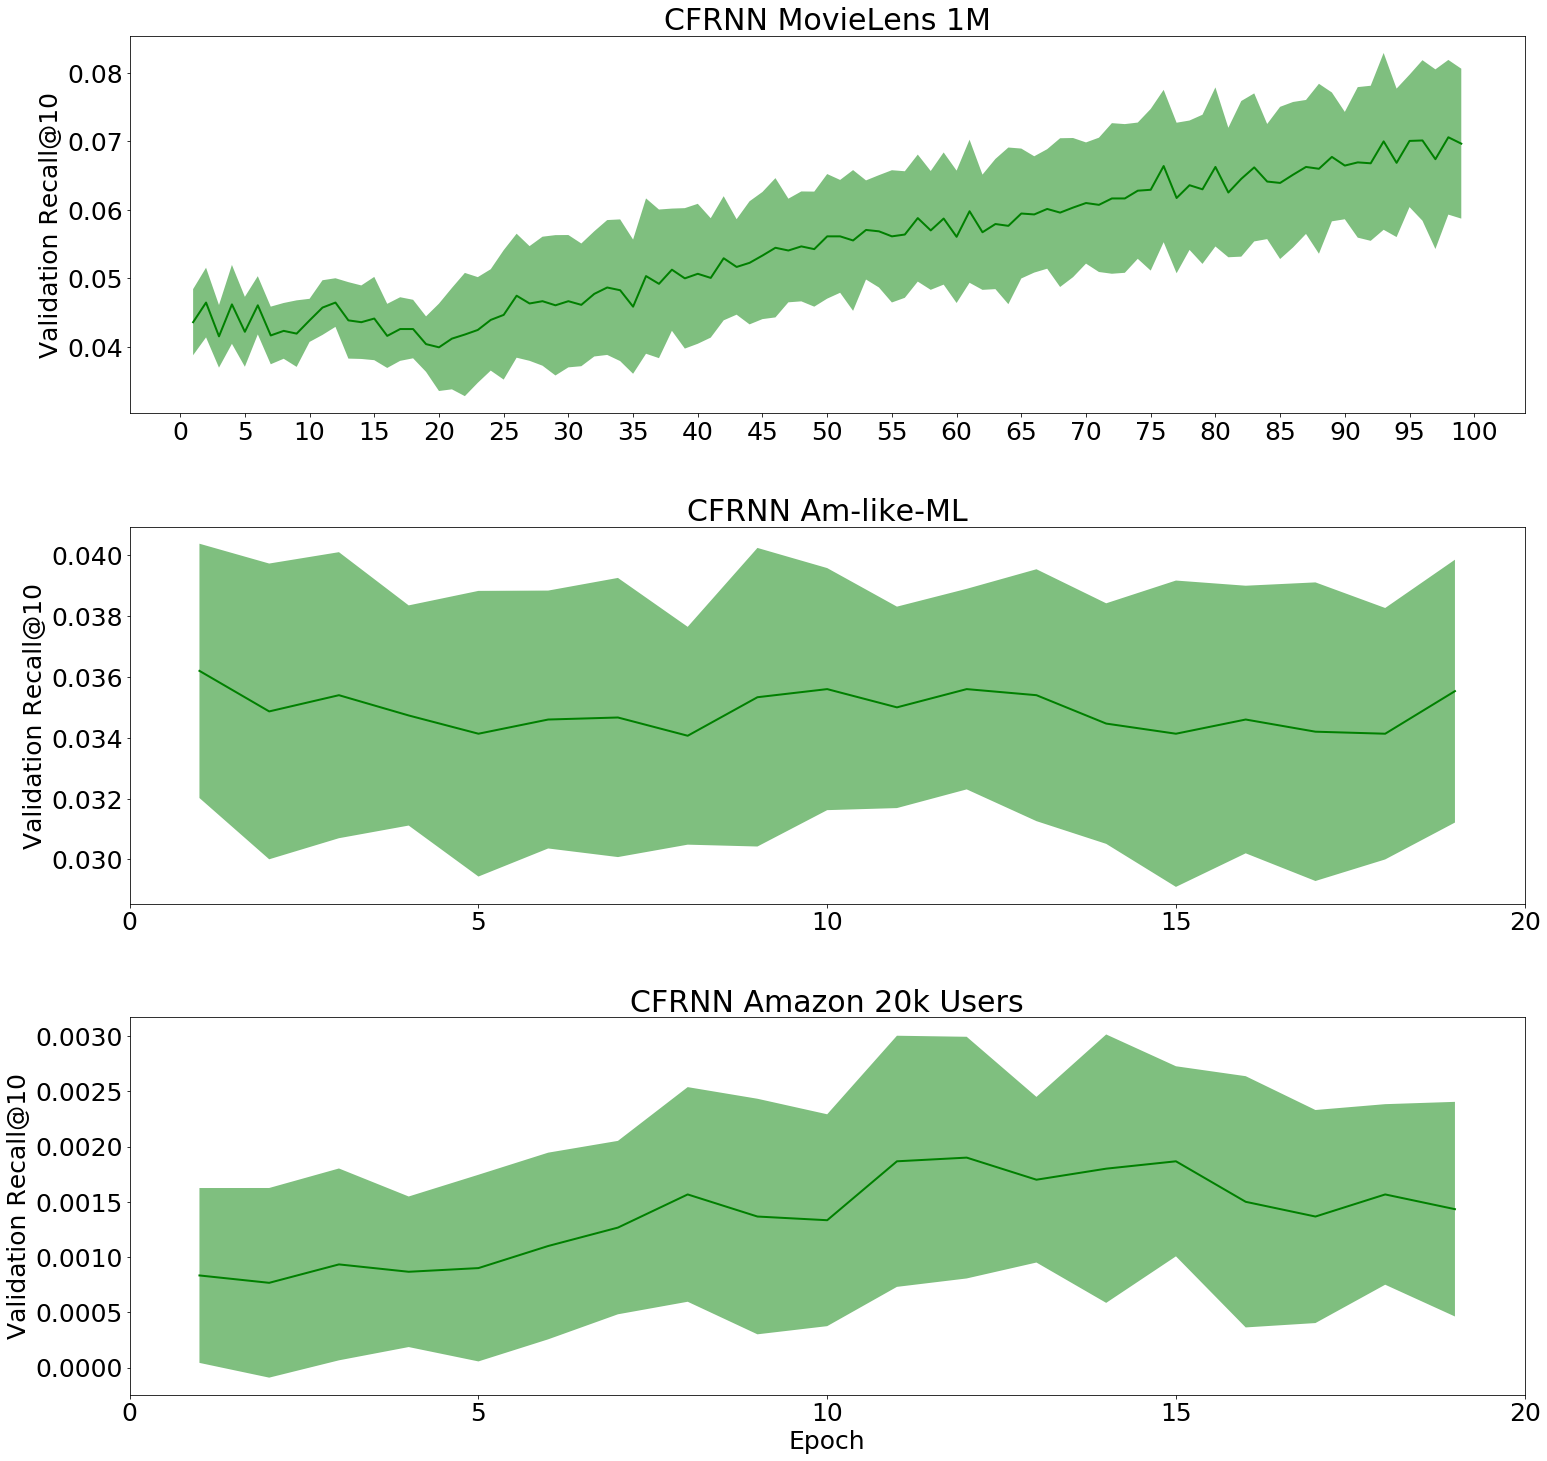

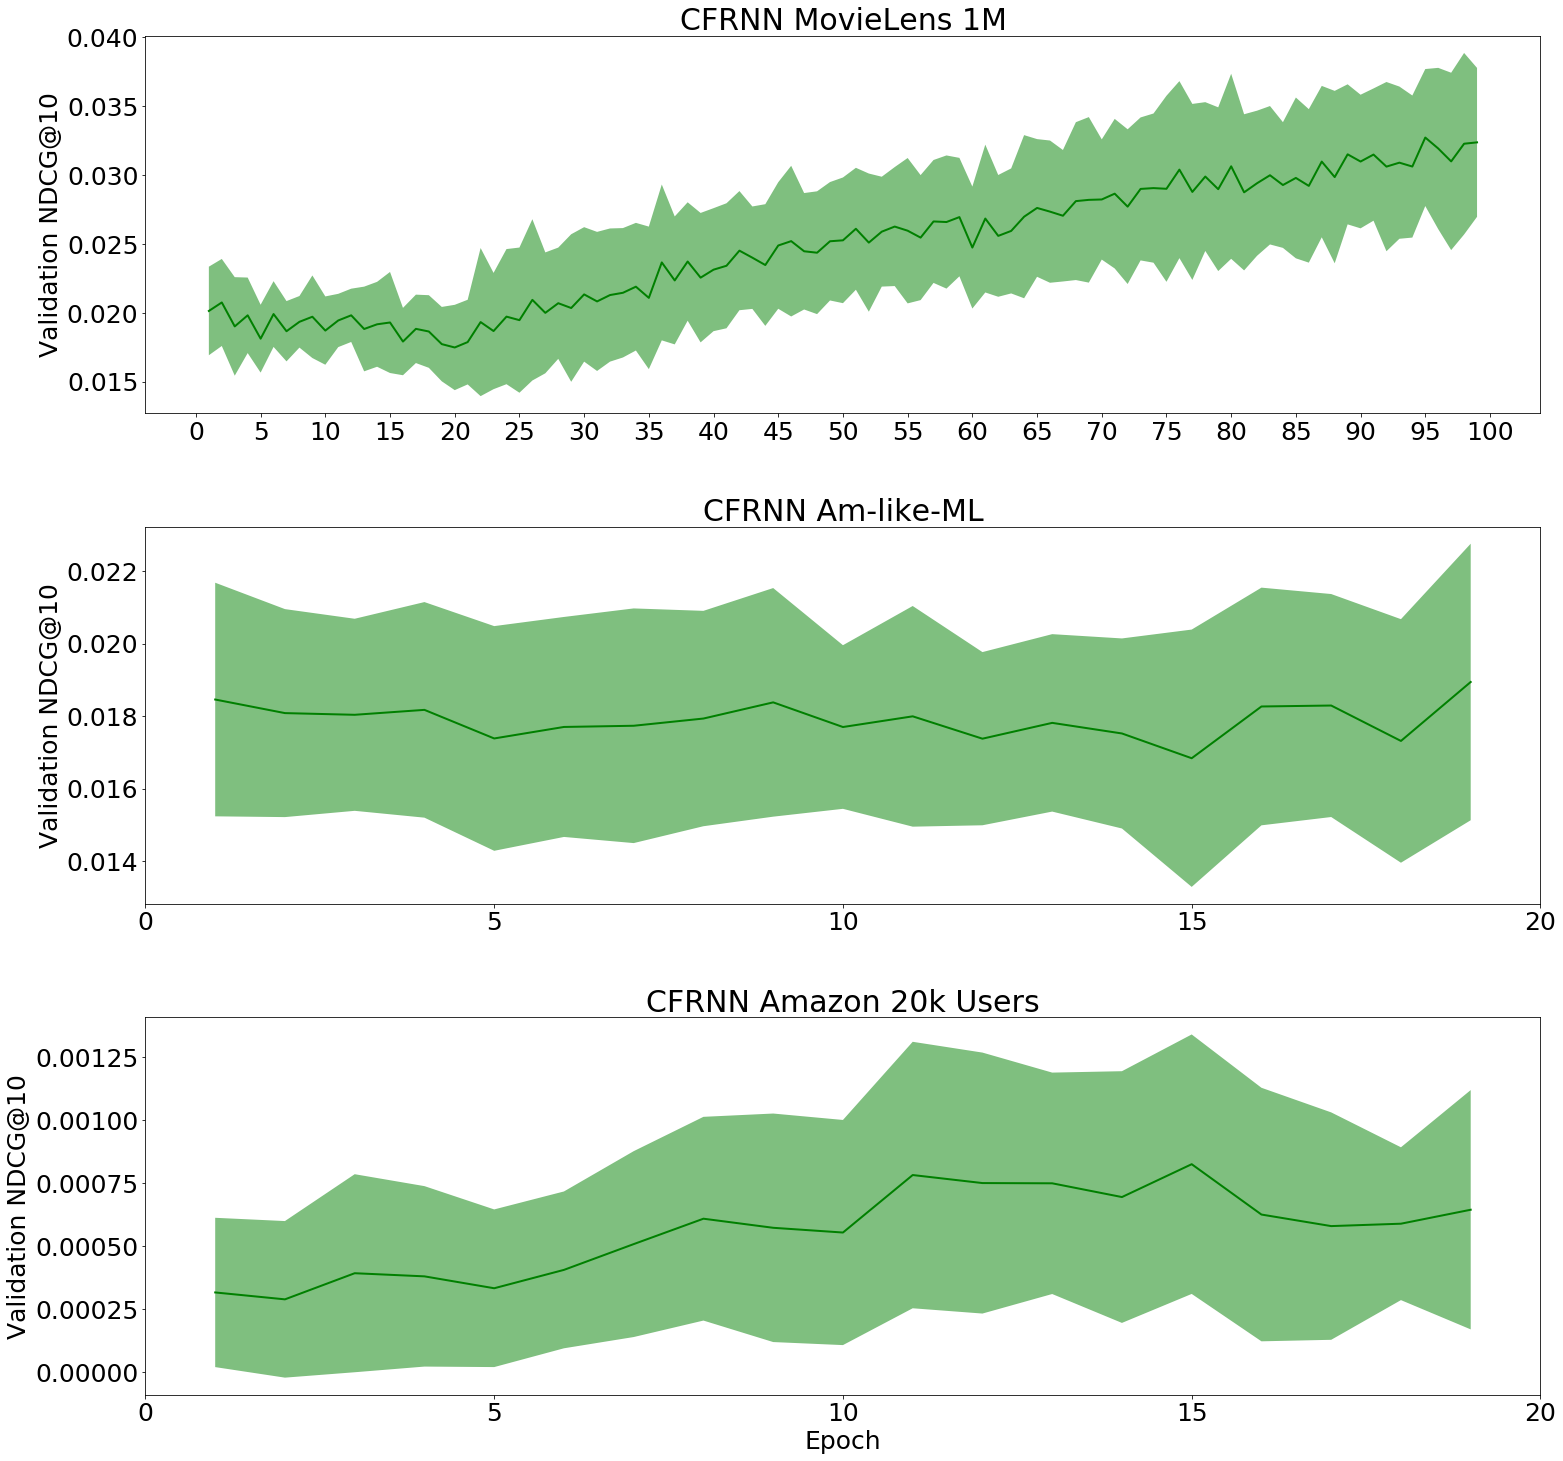

In [28]:
from visualize_results import plot_train_stat
stats = ['loss', 'val_rec@10', 'val_ndcg@10']
ylabels = ['Loss', 'Validation Recall@10', 'Validation NDCG@10']
store_path = path + 'Plots/' 

for label, color in zip(labels, colors):
    for stat, ylabel in zip(stats, ylabels):
        plot_train_stat(final_results=final_results, 
                        stat=stat, 
                        ylabel=ylabel,
                        label=label, 
                        file_names=file_names, 
                        titles=titles, 
                        color=color,
                        store_path='')#store_path + label + '/' + stat)

In [97]:
to_plot = ['loss', 'val_rec@10', 'val_ndcg@10']
ylabels = ['Loss', 'Validation Recall@10', 'Validation NDCG@10']

fig, ax = plt.subplots(figsize=size, nrows=len(to_plot), ncols=1)

{'ml_1m':     loss_mean  val_rec@10_mean  val_ndcg@10_mean  loss_std  val_rec@10_std  \
 0    0.693254         0.004667          0.002411  0.000076        0.003536   
 1    0.692346         0.014133          0.007664  0.000186        0.006033   
 2    0.687901         0.035600          0.018090  0.001835        0.008278   
 3    0.657396         0.049533          0.025706  0.012120        0.006862   
 4    0.559085         0.052133          0.026011  0.026846        0.005277   
 5    0.446451         0.053000          0.026119  0.020541        0.004323   
 6    0.378640         0.056600          0.026541  0.009307        0.004613   
 7    0.348431         0.056067          0.025801  0.003727        0.005669   
 8    0.332788         0.056067          0.028041  0.002140        0.005570   
 9    0.320742         0.054000          0.026441  0.002637        0.006259   
 10   0.310324         0.056400          0.026744  0.003460        0.005882   
 11   0.298054         0.060667          0.

## CFRNN Train Stats

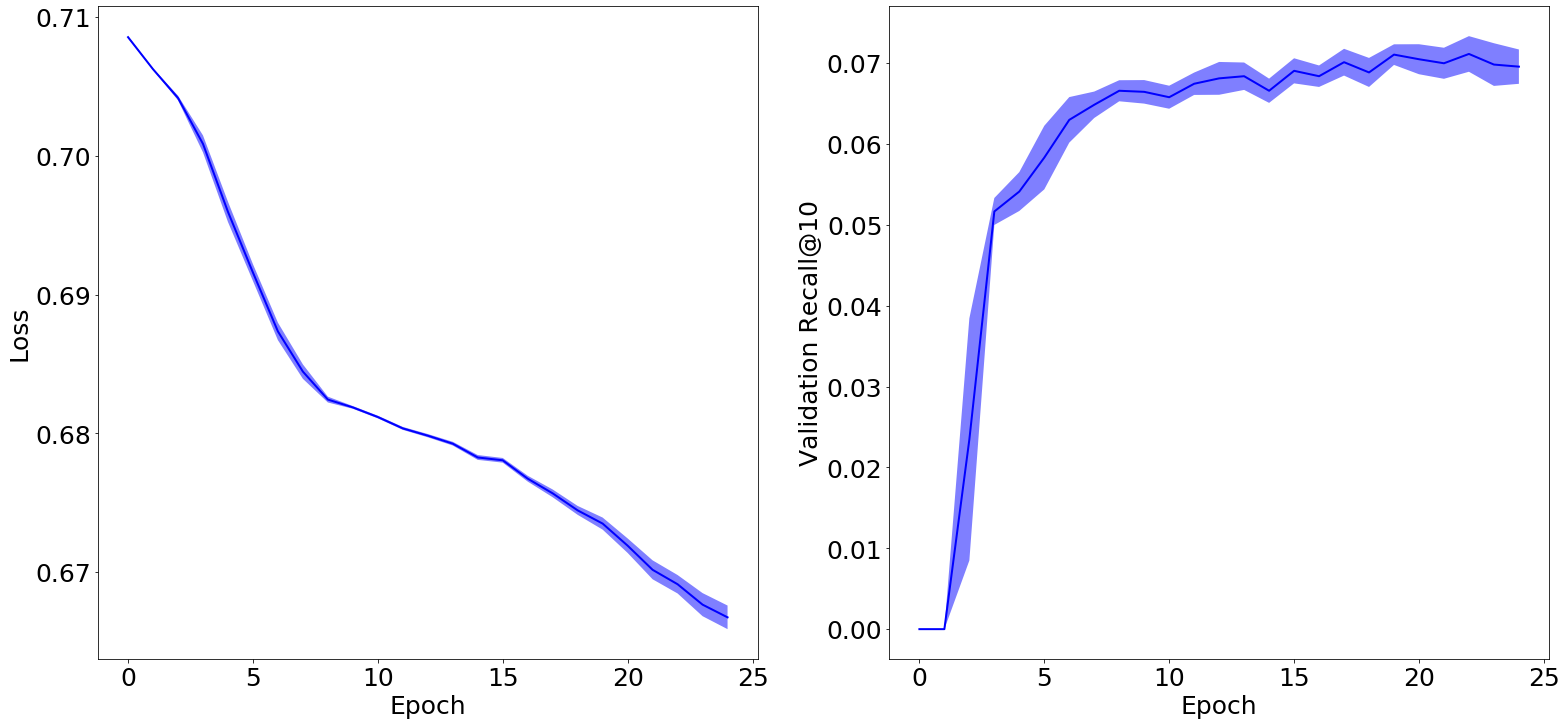

In [90]:
plot_train_stats(final_results['stats'][0], color='blue', size=(26,12))

## NeuMF Train Stats

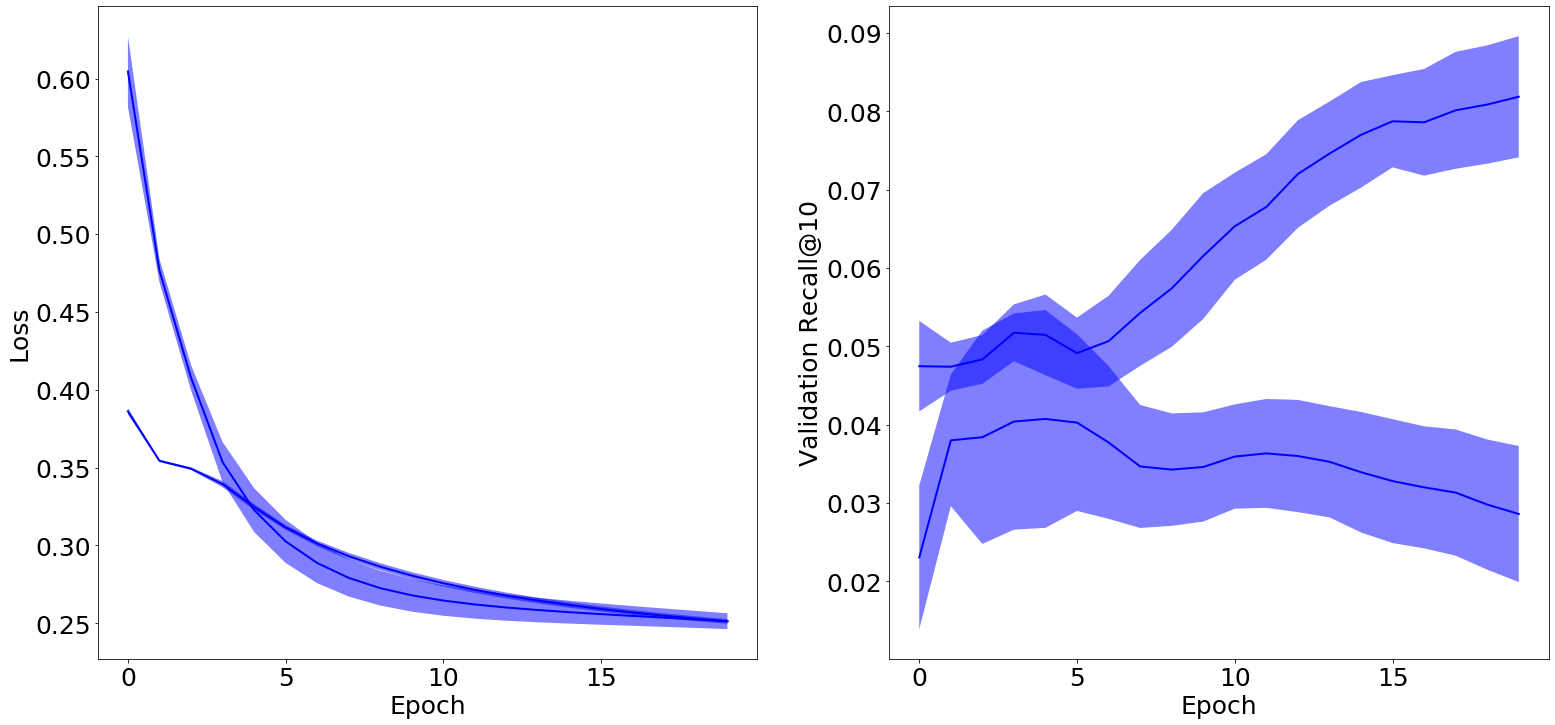

In [41]:
plot_train_stats(final_results['stats']['cfrnn'], color='blue', size=(26,12))

In [40]:
final_results

{'metrics': {'ml_1m': [   recall_mean  hitcounts_mean  ndcg_mean  recall_std  hitcounts_std  \
   0     0.006233        6.233333   0.006233    0.002459       2.459091   
   1     0.032300       32.300000   0.019025    0.003870       3.869866   
   2     0.055167       55.166667   0.026352    0.004713       4.713029   
   3     0.077700       77.700000   0.032290    0.006204       6.204281   
   4     0.097467       97.466667   0.036951    0.006611       6.611032   
   
      ndcg_std  rank_at  
   0  0.002459        1  
   1  0.002473        5  
   2  0.002586       10  
   3  0.002770       15  
   4  0.002632       20  ,
      recall_mean  hitcounts_mean  ndcg_mean  recall_std  hitcounts_std  \
   0     0.009067        9.066667   0.009067    0.002518       2.517981   
   1     0.036400       36.400000   0.022420    0.004132       4.132295   
   2     0.066633       66.633333   0.032114    0.004148       4.147981   
   3     0.092267       92.266667   0.038880    0.004152       4.1517